In [ ]:
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from sklearn.tree import DecisionTreeRegressor
#!pip install graphviz
from sklearn.tree import export_graphviz
from graphviz import Source

# Import Data

In [33]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()


In [34]:
import pandas as pd
pd.set_option("display.max_columns", 500)

In [179]:
df = pd.DataFrame(cursor.execute("""select * from combined2""").fetchall())
df.columns = [description[0] for description in cursor.description]

In [180]:
df = df.drop(columns=["index"])

In [38]:
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,nuclear_unit_id,plant_name_gen,operator_name_gen,operator_id_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen
0,5.4,23.100,NaN,0.49,NaN,IMP,NaN,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,NaN,1,None,None,F,195.0,Alabama Power Co,3,Barry,AL,RV,None,259412,REG,M,None,INTEROCEAN COAL,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,"4,208,251","4,208,251","94,561,606","94,561,606","9,472,859",2008,"340,778","340,778",22.59,"7,697,153","7,697,153","778,699"
1,5.7,22.800,NaN,0.48,NaN,IMP,NaN,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,NaN,1,None,None,F,195.0,Alabama Power Co,3,Barry,AL,RV,None,52241,REG,M,None,INTEROCEAN COAL,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,"4,208,251","4,208,251","94,561,606","94,561,606","9,472,859",2008,"340,778","340,778",22.59,"7,697,153","7,697,153","778,699"
2,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195.0,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,"3,433","3,433","3,559","3,559","1,609,033",2008,"2,400","2,400",1.04,"2,489","2,489","146,327"
3,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195.0,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,"30,932,077","30,932,077","32,090,118","32,090,118","2,858,195",2008,"2,781,102","2,781,102",1.04,"2,884,003","2,884,003","244,784"
4,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195.0,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,"837,652","837,652","871,270","871,270","87,265",2008,"109,281","109,281",1.04,"113,543","113,543","11,487"


In [181]:
df["year_month"] = df.apply(lambda x: str(x["year"]) + "-" + str(x["month"]).zfill(2), axis=1)

# Analyzing Means and Medians

In [41]:
grouped = df.groupby("year_month").median().sort_values("year_month")

In [42]:
grouped_mean = df.groupby("year_month").mean().sort_values("year_month")

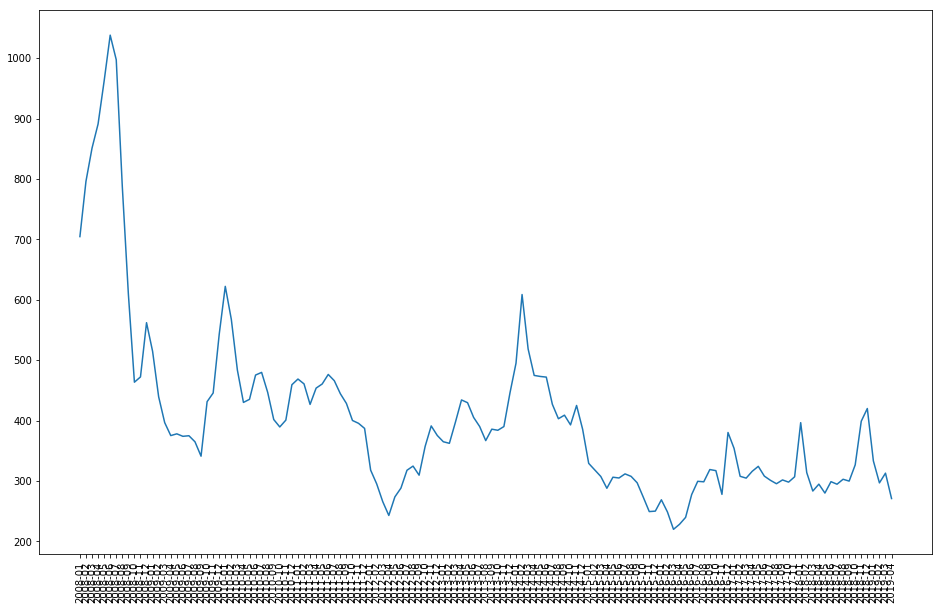

In [43]:
fig = plt.figure(figsize=(16,10))
plt.xticks(rotation=90)
plt.plot(grouped.index, grouped["fuel_cost"])


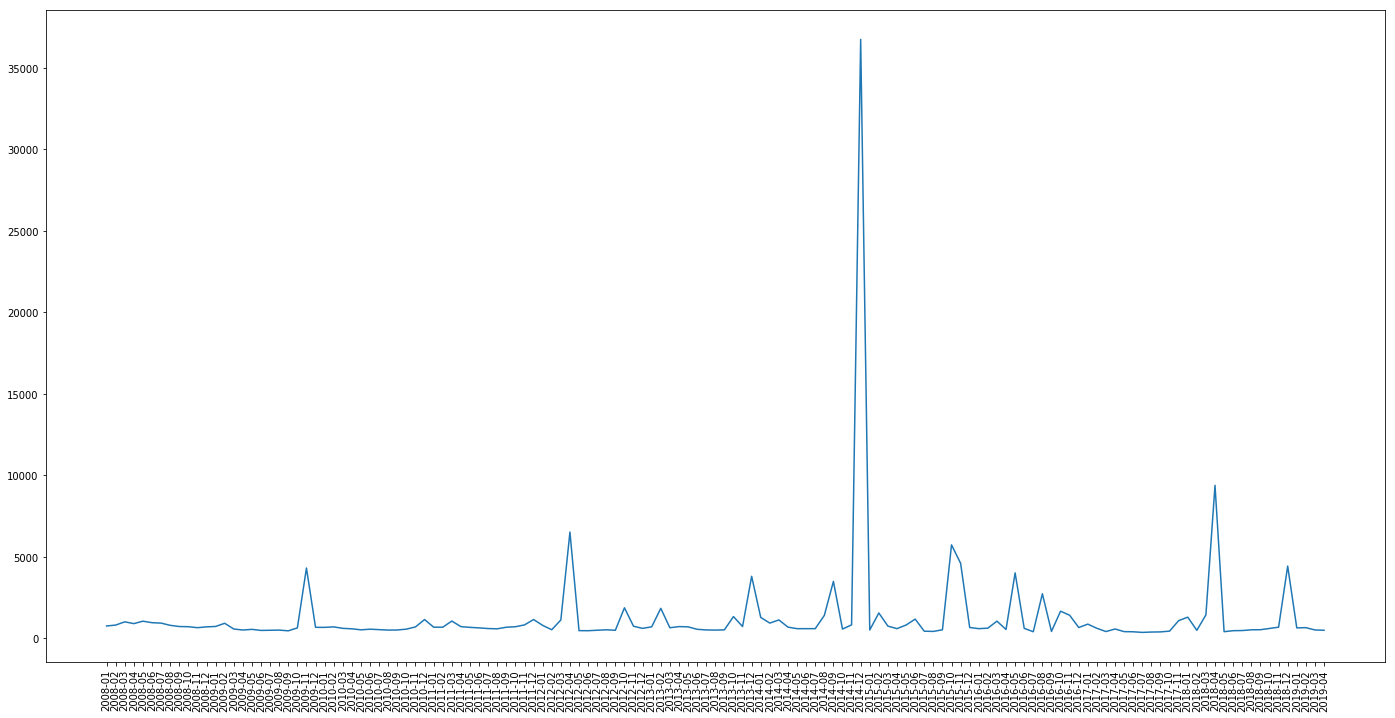

In [44]:
fig = plt.figure(figsize=(24,12))
plt.xticks(rotation=90)
plt.plot(grouped.index, grouped_mean["fuel_cost"])

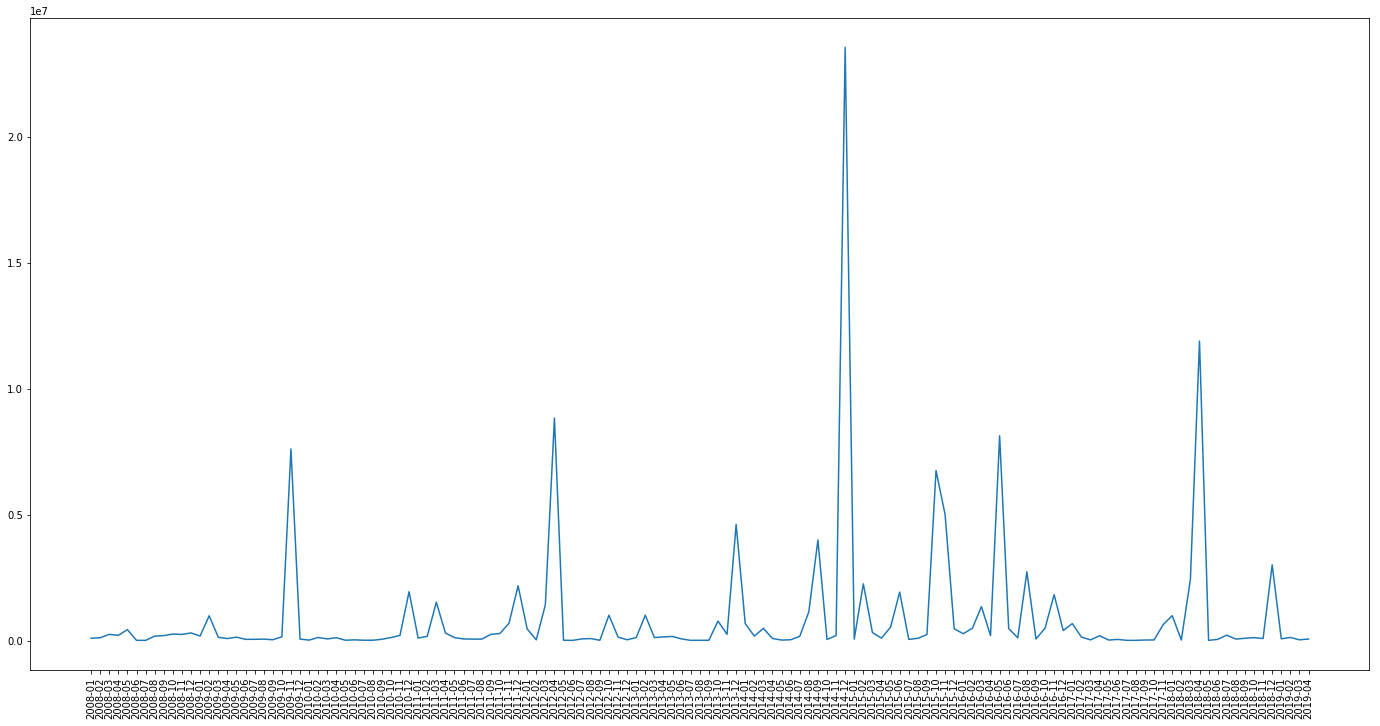

In [45]:
grouped_max = df.groupby("year_month").max().sort_values("year_month")
fig = plt.figure(figsize=(24,12))
plt.xticks(rotation=90)
plt.plot(grouped.index, grouped_max["fuel_cost"])

# Cleaning new fields

In [182]:
df["total_fuel_consumption_mmbtu"] = df["total_fuel_consumption_mmbtu"].apply(lambda x: str(x).replace(",", ""))
df["total_fuel_consumption_mmbtu"] = df["total_fuel_consumption_mmbtu"].astype(int)

In [183]:
def none_to_zero(x):
    if (x=="None") or (x == "."):
        return 0
    else:
        return x

In [184]:
fields_to_clean = ["total_fuel_consumption_quantity", "electric_fuel_consumption_quantity", "total_fuel_consumption_mmbtu", "elec_fuel_consumption_mmbtu", "net_generation_megawatthours", "quantity_gen", "elec_quantity_gen", "tot_mmbtu_gen", "elec_mmbtu_gen", "netgen_gen"]


In [185]:
for fld in fields_to_clean:
    df[fld] = df[fld].apply(lambda x: str(x).replace(",", ""))
#    df[fld] = df[fld].astype(int)

In [186]:
#"mmbtu_per_unit_gen"
for fld in fields_to_clean:
    df[fld] = df[fld].apply(none_to_zero)


In [187]:
for fld in fields_to_clean:
    df[fld] = df[fld].apply(lambda x: str(x).replace(",", ""))


In [188]:
for fld in fields_to_clean:
    df[fld] = df[fld].astype(int)

In [189]:
# if fuel_cost isnt defined, its no use to us
df = df[df.fuel_cost.notna()].copy()

In [192]:
def try_float(x):
    if x =="" or x == None or x == ".":
        return 0
    else:
        return float(x)
df["mmbtu_per_unit_gen"] = df["mmbtu_per_unit_gen"].apply(try_float)

In [193]:
df["mmbtu_per_unit_gen"] = df["mmbtu_per_unit_gen"].astype(float)

# Correlations

In [142]:
corr = df.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['plant_id', 'plant_id', 1.0],
 ['year', 'year', 1.0],
 ['plant_id_gen', 'plant_id', 1.0],
 ['year_gen', 'year', 1.0],
 ['total_fuel_consumption_mmbtu',
  'elec_fuel_consumption_mmbtu',
  0.9999770523862502],
 ['elec_fuel_consumption_mmbtu',
  'total_fuel_consumption_mmbtu',
  0.9999770523862502],
 ['tot_mmbtu_gen', 'elec_mmbtu_gen', 0.9999716180715355],
 ['elec_mmbtu_gen', 'tot_mmbtu_gen', 0.9999716180715355],
 ['total_fuel_consumption_quantity',
  'electric_fuel_consumption_quantity',
  0.9999369008341337],
 ['electric_fuel_consumption_quantity',
  'total_fuel_consumption_quantity',
  0.9999369008341337],
 ['quantity_gen', 'elec_quantity_gen', 0.9999116124422696],
 ['elec_quantity_gen', 'quantity_gen', 0.9999116124422696],
 ['elec_fuel_consumption_mmbtu',
  'net_generation_megawatthours',
  0.9918196994462372],
 ['net_generation_megawatthours',
  'elec_fuel_consumption_mmbtu',
  0.9918196994462372],
 ['total_fuel_consumption_mmbtu',
  'net_generation_megawatthours',
  0.991808116513

### Correlations involving fuel_cost

In [143]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20] 

[['chlorine_content', 'fuel_cost', 0.23149250910755437],
 ['fuel_cost', 'chlorine_content', 0.23149250910755437],
 ['fuel_cost', 'month', 0.005649147631898076],
 ['month', 'fuel_cost', 0.005649147631898076],
 ['fuel_cost', 'plant_id', 0.004949768410202081],
 ['fuel_cost', 'plant_id_gen', 0.004949768410202081],
 ['plant_id', 'fuel_cost', 0.004949768410202081],
 ['plant_id_gen', 'fuel_cost', 0.004949768410202081],
 ['fuel_cost', 'year', 0.00345659268292363],
 ['fuel_cost', 'year_gen', 0.00345659268292363],
 ['year', 'fuel_cost', 0.00345659268292363],
 ['year_gen', 'fuel_cost', 0.00345659268292363],
 ['fuel_cost', 'operator_id_gen', 0.002836888532089242],
 ['operator_id_gen', 'fuel_cost', 0.002836888532089242],
 ['fuel_cost', 'naics_code', -0.0001083942804218585],
 ['naics_code', 'fuel_cost', -0.0001083942804218585],
 ['fuel_cost', 'eia_sector_number', -0.00014306712983245778],
 ['eia_sector_number', 'fuel_cost', -0.00014306712983245778],
 ['fuel_cost', 'electric_fuel_consumption_quantity

# Split Up By Fuel Type

In [173]:

df_ng = df[df["fuel_group"] == "Natural Gas"]
df_p = df[df["fuel_group"] == "Petroleum"]
df_pc = df[df["fuel_group"] == "Petroleum Coke"]
df_og = df[df["fuel_group"] == "Other Gas"]

## Analysis of Coal

In [314]:
def get_coal():
    df_c = df[df["fuel_group"] == "Coal"].copy()
    df_c.coalmine_msha_id = df_c.coalmine_msha_id.fillna(value="N/A")
    df_c.chlorine_content = df_c.chlorine_content.fillna(value=0)
    df_c.average_mercury_content = df_c.average_mercury_content.fillna(value=0)
    df_c.moisture_content = df_c.moisture_content.fillna(value=df_c.moisture_content.median())
    return df_c

In [241]:
coal_fields = ["fuel_cost", "average_ash_content", "average_heat_content", "average_mercury_content", "average_sulfur_content", "chlorine_content", "coalmine_county", "coalmine_msha_id", "coalmine_state", "coalmine_type", "contract_type", "energy_source", "moisture_content",  "operator_id", "plant_id", "plant_state", "primary_transportation_mode", "purchase_type", "quantity", "regulated", "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "net_generation_megawatthours", "mmbtu_per_unit_gen", "year_month"]

In [166]:
df_c[coal_fields].head()

,fuel_cost,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,moisture_content,operator_id,plant_id,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,combined_heat_and_power_plant,nerc_region,reported_prime_mover,net_generation_megawatthours,mmbtu_per_unit_gen,year_month
0,213.5,5.4,23.100,0.0,0.49,0.0,IMP,N/A,CL,SU,408.0,C,BIT,923.5,195.0,3,AL,RV,None,259412,REG,M,None,INTEROCEAN COAL,N,SERC,ST,9472859,2259.0,2008-01
1,211.5,5.7,22.800,0.0,0.48,0.0,IMP,N/A,CL,SU,408.0,C,BIT,923.5,195.0,3,AL,RV,None,52241,REG,M,None,INTEROCEAN COAL,N,SERC,ST,9472859,2259.0,2008-01
5,277.6,14.7,24.610,0.0,1.69,0.0,007,N/A,AL,SU,1215.0,C,BIT,923.5,195.0,7,AL,TR,None,25397,REG,A,None,ALABAMA COAL,N,SERC,ST,589213,2418.0,2008-01
6,338.1,15.5,24.446,0.0,0.84,0.0,145,N/A,AL,S,1108.0,S,BIT,923.5,195.0,7,AL,TR,None,764,REG,A,None,D & E MINING,N,SERC,ST,589213,2418.0,2008-01
7,219.9,14.6,24.577,0.0,1.54,0.0,127,N/A,AL,S,108.0,S,BIT,923.5,195.0,7,AL,TR,None,603,REG,A,None,ALABAMA COAL,N,SERC,ST,589213,2418.0,2008-01


### Linear Model Without Category Features

In [265]:
not_encode = []
to_encode = []
for fld, fld_type in df_c[coal_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)

In [317]:
df_c = get_coal()
df_c = df_c[not_encode]



In [318]:
df_c.head()

,fuel_cost,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,moisture_content,plant_id,quantity,net_generation_megawatthours,mmbtu_per_unit_gen
0,213.5,5.4,23.100,0.0,0.49,0.0,923.5,3,259412,9472859,22.59
1,211.5,5.7,22.800,0.0,0.48,0.0,923.5,3,52241,9472859,22.59
5,277.6,14.7,24.610,0.0,1.69,0.0,923.5,7,25397,589213,24.18
6,338.1,15.5,24.446,0.0,0.84,0.0,923.5,7,764,589213,24.18
7,219.9,14.6,24.577,0.0,1.54,0.0,923.5,7,603,589213,24.18


In [319]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [339]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=False,
    normalize=True,
    copy_X=False,
    n_jobs=50,)
results = linreg.fit(X_train, y_train)

In [340]:
results.score(X_test, y_test)

0.3743336394136867

In [341]:
y_pred = results.predict(X_test)

In [342]:
mean_squared_error(y_test, y_pred)

5666.232653314403

In [325]:
model = OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 1.271e+05
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:49:42   Log-Likelihood:            -6.3179e+05
No. Observations:              110054   AIC:                         1.264e+06
Df Residuals:                  110044   BIC:                         1.264e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
average_ash_content              3.3164      0.067     49.564      0.000       3.185       3.447
average_heat_content            13.3367      0.052    255.101      0.000      13.234      13.439
average_mercury_content          2.1089      0.099     21.204      0.000       1.914       2.304
average_sulfur_content         -21.7748      0.231    -94.371      0.000     -22.227     -21.323
chlorine_content                -0.0001   2.47e-05     -4.493      0.000      -0.000   -6.25e-05
moisture_content                -0.0131      0.001    -25.489      0.000      -0.014      -0.012
plant_id                        -0.0012   4.05e-05    -29.517      0.000      -0.001      -0.001
quantity                        -0.0001   3.14e-06    -33.517      0.000      -0.000   -9.91e-05
net_generation_megawatthours -1.089e-06   4.92e-08    -22.112      0.000   -1.19e-06   -9.92e-07
mmbtu_per_unit_gen              -0.3487      0.041     -8.428      0.000      -0.430      -0.268
==============================================================================
Omnibus:                    65923.889   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5399853.640
Skew:                           2.057   Prob(JB):                         0.00
Kurtosis:                      37.068   Cond. No.                     7.82e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [346]:

model = DecisionTreeRegressor(random_state=23)
results = model.fit(X_train, y_train)


In [347]:
results.score(X_train, y_train)

0.9999902352879712

In [348]:
results.score(X_test, y_test)

0.647820574419568

In [349]:
y_pred = model.predict(X_test)

In [350]:
mean_squared_error(y_test, y_pred)

3189.448381369485

In [1]:
graph = Source( export_graphviz(results, out_file=None, feature_names=X.columns))
graph.render(filename="tree.png", format="png")


### Now With All One-Hot Encoded Category Features

In [249]:
temp1 = df_c[not_encode].reset_index()
temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [250]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = OLS(y_train,X_train)
results = model.fit()

In [251]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     143.6
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:53:12   Log-Likelihood:            -5.7843e+05
No. Observations:              110054   AIC:                         1.162e+06
Df Residuals:                  107616   BIC:                         1.185e+06
Df Model:                        2437                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
average_ash_content                                            -0.4689      0.141     -3.331      0.001      -0.745      -0.193
average_heat_content                                            4.4851      0.352     12.745      0.000       3.795       5.175
average_mercury_content                                        -0.2150      0.146     -1.469      0.142      -0.502       0.072
average_sulfur_content                                         -9.1790      0.557    -16.465      0.000     -10.272      -8.086
chlorine_content                                            -6.538e-05   1.62e-05     -4.044      0.000   -9.71e-05   -3.37e-05
moisture_content                                                0.0039      0.000      9.609      0.000       0.003       0.005
plant_id                                                      8.58e-05   4.04e-05      2.122      0.034    6.56e-06       0.000
quantity                                                    -3.904e-05    3.1e-06    -12.594      0.000   -4.51e-05    -3.3e-05
net_generation_megawatthours                                  -1.4e-06   4.66e-08    -30.037      0.000   -1.49e-06   -1.31e-06
mmbtu_per_unit_gen                                              0.1698      0.037      4.553      0.000       0.097       0.243
coalmine_county_  3                                           -19.5675     54.822     -0.357      0.721    -127.019      87.884
coalmine_county_  5                                             4.1782      4.825      0.866      0.387      -5.279      13.636
coalmine_county_  9                                            -1.6212     24.188     -0.067      0.947     -49.030      45.788
coalmine_county_ 13                                           -22.7484     28.257     -0.805      0.421     -78.132      32.635
coalmine_county_ 19                                            39.5973     15.341      2.581      0.010       9.529      69.666
coalmine_county_ 25                                           -44.1968     16.170     -2.733      0.006     -75.889     -12.505
coalmine_county_ 27                                             0.3257     28.299      0.012      0.991     -55.140      55.791
coalmine_county_ 29                                           -58.7897     21.684     -2.711      0.007    -101.291     -16.289
coalmine_county_ 31                                           -42.8113     16.783     -2.551      0.011     -75.705      -9.917
coalmine_county_ 33                                           -89.9258     47.171     -1.906      0.057    -182.381       2.529
coalmine_county_ 39                                           -22.7538      6.608     -3.443      0.001     -35.706      -9.802
coalmine_co

### Lots of features so sorting by largest coefficients

In [259]:
sorted(results.params.items(),key=lambda x: x[1], reverse=True)[0:50]

[('supplier_CEMEX', 675.675764749041),
 ('coalmine_msha_id_4608247.0', 487.5381454550442),
 ('supplier_ECI/VENEZUELA', 455.6097762690006),
 ('supplier_SPECIALIZED FUELS LLC', 407.84598254320866),
 ('supplier_CALENTURITAS', 357.70133693360424),
 ('coalmine_county_ 95', 344.13288653045834),
 ('supplier_GENESIS CONSULTING', 340.1222122504805),
 ('coalmine_state_ID', 334.5170586267999),
 ('coalmine_msha_id_1518922.0', 314.9922012874162),
 ('supplier_VIRGINIA ELEC', 289.898324124297),
 ('supplier_GUASARE', 272.7152310149398),
 ('coalmine_msha_id_4407180.0', 270.9280407140242),
 ('coalmine_msha_id_3600958.0', 266.20056712557147),
 ('coalmine_msha_id_4202028.0', 257.36321773931076),
 ('coalmine_msha_id_1202414.0', 256.6325105119255),
 ('supplier_TONYS FORK', 255.2222177371772),
 ('supplier_ELK MOUNTAIN', 246.94564836905832),
 ('supplier_NEW RIVER', 240.83547555148024),
 ('supplier_STONE COAL', 240.53249980373414),
 ('coalmine_county_65.0', 238.0394638775868),
 ('supplier_FOUNDATION ENERGY SAL

In [255]:
df[df["supplier"] == "CEMEX"][["fuel_cost", "year_month"]]
# mexican cement manufacturer with only one entry during polar vortex

,fuel_cost,year_month
247957,1052.2,2014-02


In [256]:
#GENESIS CONSULTING
df[df["supplier"] == "GENESIS CONSULTING"][["fuel_cost", "year_month"]]

,fuel_cost,year_month
49883,665.9,2008-08


### Some of these suppliers with large coefs only supplied for one year, when prices were high

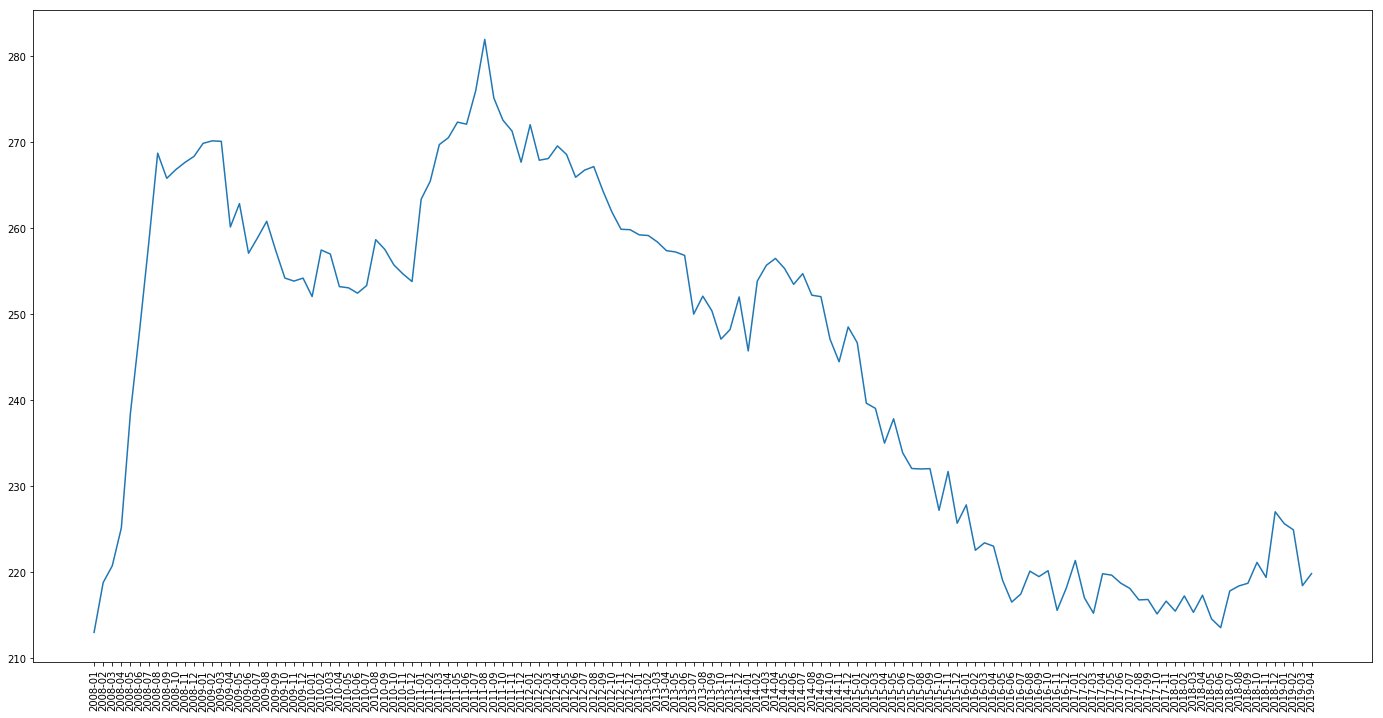

In [258]:
grouped_mean = df[df["fuel_group"] == "Coal"].groupby("year_month").mean()
fig = plt.figure(figsize=(24,12))
plt.xticks(rotation=90)
plt.plot(grouped_mean.index, grouped_mean["fuel_cost"])

### Another model, without suppliers

In [263]:
df_c = df[df["fuel_group"] == "Coal"].copy()
df_c.coalmine_msha_id = df_c.coalmine_msha_id.fillna(value="N/A")
df_c.chlorine_content = df_c.chlorine_content.fillna(value=0)
df_c.average_mercury_content = df_c.average_mercury_content.fillna(value=0)
df_c.moisture_content = df_c.moisture_content.fillna(value=df_c.moisture_content.median())

In [266]:
to_encode2 = to_encode
to_encode2.remove("supplier")
temp1 = df_c[not_encode].reset_index()
temp2 = pd.get_dummies(df_c[to_encode2]).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [267]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = OLS(y_train,X_train)
results = model.fit()

In [268]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     191.8
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:22:46   Log-Likelihood:            -5.8602e+05
No. Observations:              110054   AIC:                         1.175e+06
Df Residuals:                  108519   BIC:                         1.190e+06
Df Model:                        1534                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
average_ash_content                 -0.4267      0.138     -3.087      0.002      -0.698      -0.156
average_heat_content                 5.9747      0.338     17.675      0.000       5.312       6.637
average_mercury_content             -0.2956      0.154     -1.913      0.056      -0.598       0.007
average_sulfur_content              -9.1343      0.539    -16.941      0.000     -10.191      -8.078
chlorine_content                 -3.893e-05   1.68e-05     -2.319      0.020   -7.18e-05   -6.02e-06
moisture_content                     0.0058      0.000     13.563      0.000       0.005       0.007
plant_id                          2.639e-05   3.92e-05      0.673      0.501   -5.05e-05       0.000
quantity                         -3.989e-05   3.18e-06    -12.544      0.000   -4.61e-05   -3.37e-05
net_generation_megawatthours     -1.441e-06   4.79e-08    -30.058      0.000   -1.53e-06   -1.35e-06
mmbtu_per_unit_gen                   0.1073      0.039      2.777      0.005       0.032       0.183
coalmine_county_  3                 42.0025     25.505      1.647      0.100      -7.987      91.992
coalmine_county_  5                 43.2316      4.633      9.332      0.000      34.151      52.312
coalmine_county_  9                 94.6693     14.415      6.567      0.000      66.416     122.923
coalmine_county_ 13                -18.9772     35.714     -0.531      0.595     -88.976      51.021
coalmine_county_ 19                 45.5877     14.229      3.204      0.001      17.699      73.476
coalmine_county_ 25                -43.2076     19.257     -2.244      0.025     -80.951      -5.464
coalmine_county_ 27                 49.7667     29.511      1.686      0.092      -8.075     107.609
coalmine_county_ 29                -84.6049     16.601     -5.096      0.000    -117.142     -52.068
coalmine_county_ 31                -34.1567     14.054     -2.430      0.015     -61.703      -6.611
coalmine_county_ 33               -119.2819     50.207     -2.376      0.018    -217.686     -20.878
coalmine_county_ 39                  1.2082      6.689      0.181      0.857     -11.902      14.318
coalmine_county_ 45                -17.2358      7.419     -2.323      0.020     -31.776      -2.695
coalmine_county_ 47                -71.1063     29.118     -2.442      0.015    -128.177     -14.035
coalmine_county_ 51               -104.9369     50.218     -2.090      0.037    -203.363      -6.511
coalmine_county_ 53                -53.0895     14.339     -3.702      0.000     -81.194     -24.984
coalmine_county_ 59                 85.5362      9.970      8.580      0.000      65.996     105.077
coalmine_county_ 61                 17.2966     22.675      0.763      0.446     -27.147      61.740
coalmine_county_ 65                 91.1423     37.90

In [269]:
sorted(results.params.items(),key=lambda x: x[1], reverse=True)[0:20]

[('coalmine_msha_id_4608247.0', 474.6145646021431),
 ('coalmine_state_ID', 401.79294240770173),
 ('coalmine_county_ 95', 311.7005924947425),
 ('coalmine_msha_id_1518267.0', 286.3889377028155),
 ('coalmine_msha_id_1518922.0', 285.22093865256545),
 ('coalmine_msha_id_4406505.0', 275.81412072050057),
 ('coalmine_msha_id_3600958.0', 264.20716609461346),
 ('coalmine_msha_id_4801694.0', 253.04929700306818),
 ('coalmine_msha_id_1519075.0', 225.92220064116393),
 ('coalmine_msha_id_1518196.0', 224.60013990209475),
 ('coalmine_msha_id_4003199.0', 212.2309901762902),
 ('coalmine_msha_id_1517880.0', 208.13301287496438),
 ('coalmine_msha_id_4003213.0', 206.6278138107151),
 ('coalmine_msha_id_4407180.0', 205.9404146856818),
 ('coalmine_msha_id_4608767.0', 199.9232955539448),
 ('operator_id_19856.0', 199.48566385359754),
 ('plant_state_NJ', 199.48566385359675),
 ('coalmine_msha_id_1102797.0', 186.89171516330669),
 ('coalmine_msha_id_4406822.0', 185.3119924482945),
 ('coalmine_msha_id_4202028.0', 183.

In [270]:
df[df["coalmine_msha_id"] == 4608247.0][["fuel_cost", "year_month"]]

,fuel_cost,year_month
52960,772.8,2008-08
60504,774.4,2008-09


### Examining only those with chlorine values defined since there was such a high correlation with fuel_cost

In [229]:
df_c = df[(df["fuel_group"] == "Coal") & (df["chlorine_content"].notna())].copy()

In [230]:
df_c.coalmine_msha_id = df_c.coalmine_msha_id.fillna(value="N/A")

In [203]:
df_c.isna().sum()

fuel_cost                         0
average_ash_content               0
average_heat_content              0
average_mercury_content           0
average_sulfur_content            0
chlorine_content                  0
moisture_content                  0
plant_id                          0
quantity                          0
net_generation_megawatthours      0
mmbtu_per_unit_gen                0
coalmine_msha_id                381
coalmine_county_1                 0
coalmine_county_103               0
coalmine_county_105               0
coalmine_county_107               0
coalmine_county_109               0
coalmine_county_11                0
coalmine_county_115               0
coalmine_county_117               0
coalmine_county_119               0
coalmine_county_121               0
coalmine_county_125               0
coalmine_county_127               0
coalmine_county_13                0
coalmine_county_131               0
coalmine_county_133               0
coalmine_county_135         

In [231]:
temp1 = df_c[not_encode].reset_index()
temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
#df_c = df_c[not_encode].reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [211]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = OLS(y_train,X_train)
results = model.fit()

In [212]:
results.summary()

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     53.11
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:27:54   Log-Likelihood:                -34696.
No. Observations:                7284   AIC:                         7.061e+04
Df Residuals:                    6675   BIC:                         7.481e+04
Df Model:                         608                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
average_ash_content                                      -2.0502      0.611     -3.354      0.001      -3.249      -0.852
average_heat_content                                     -5.1414      1.432     -3.589      0.000      -7.949      -2.333
average_mercury_content                                   4.0326      1.893      2.130      0.033       0.322       7.743
average_sulfur_content                                    3.1412      2.526      1.244      0.214      -1.810       8.092
chlorine_content                                      -3.984e-05   1.87e-05     -2.128      0.033   -7.66e-05   -3.13e-06
moisture_content                                          0.0012      0.001      1.722      0.085      -0.000       0.003
plant_id                                                  0.0011   9.27e-05     11.719      0.000       0.001       0.001
quantity                                              -7.665e-06   7.91e-06     -0.969      0.333   -2.32e-05    7.84e-06
net_generation_megawatthours                          -2.583e-07   1.91e-07     -1.353      0.176   -6.33e-07    1.16e-07
mmbtu_per_unit_gen                                       -0.0335      0.097     -0.345      0.730      -0.224       0.157
coalmine_county_1                                        -6.5276     13.432     -0.486      0.627     -32.859      19.803
coalmine_county_103                                     -24.2793      8.584     -2.828      0.005     -41.107      -7.452
coalmine_county_105                                      40.0802     13.098      3.060      0.002      14.403      65.757
coalmine_county_107                                     -14.4476     11.842     -1.220      0.223     -37.662       8.767
coalmine_county_109                                     -55.1934     12.466     -4.427      0.000     -79.631     -30.755
coalmine_county_11                                      -13.1466     17.908     -0.734      0.463     -48.253      21.959
coalmine_county_115                                     -14.4102     14.535     -0.991      0.322     -42.903      14.083
coalmine_county_117                                     -30.1392     12.255     -2.459      0.014     -54.164      -6.115
coalmine_county_119                                      25.7764     23.592      1.093      0.275     -20.472      72.025
coalmine_county_121                                     -23.7322      5.560     -4.268      0.000     -34.632     -12.832
coalmine_county_125                                     -14.4301     15.036     -0.960      0.337     -43.905      15.045
coalmine_county_127                                      29.0425     20.711      1.402      0.161     -11.557      69.642
coalmine_county_13               

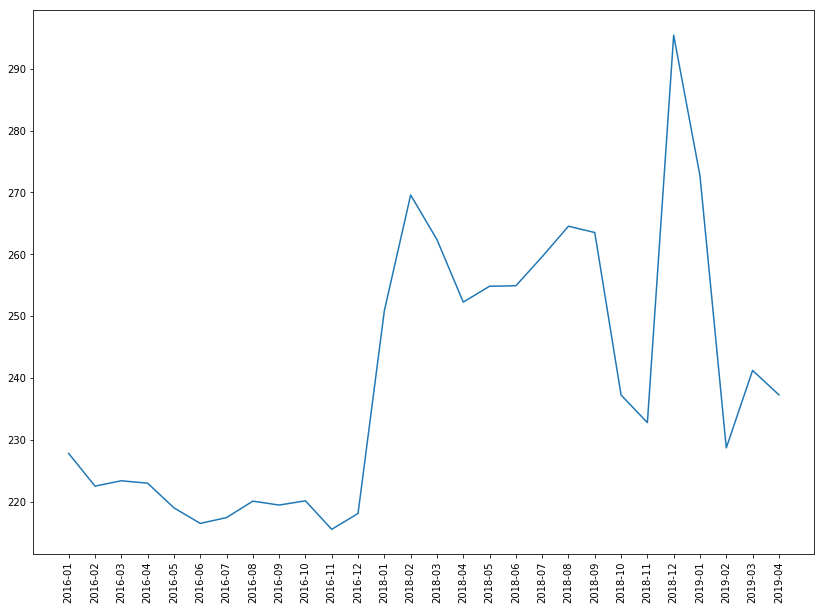

In [221]:
fig = plt.figure(figsize=(14,10))
plt.xticks(rotation=90)
grouped = df_c.groupby("year_month").mean()
grouped = grouped.sort_values("year_month", ascending=True)
plt.plot(grouped.index, grouped.fuel_cost)